In [3]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [4]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('C://Users//satya//Documents//Prodigy_InfoTech//Hand_Gesture_Recognition_04'):
    if not j.startswith('.'): # If running this code locally, this is to 
                              # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'02_l': 0,
 '04_fist_moved': 1,
 '09_c': 2,
 '10_down': 3,
 '06_index': 4,
 '08_palm_moved': 5,
 '07_ok': 6,
 '05_thumb': 7,
 '01_palm': 8,
 '03_fist': 9}

In [6]:
x_data = []
y_data = []
IMG_SIZE = 150
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('C://Users//satya//Documents//Prodigy_InfoTech//Hand_Gesture_Recognition_04' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('C://Users//satya//Documents//Prodigy_InfoTech//Hand_Gesture_Recognition_04' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                path = 'C://Users//satya//Documents//Prodigy_InfoTech//Hand_Gesture_Recognition_04' + str(i) + '/' + j + '/' + k
                img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

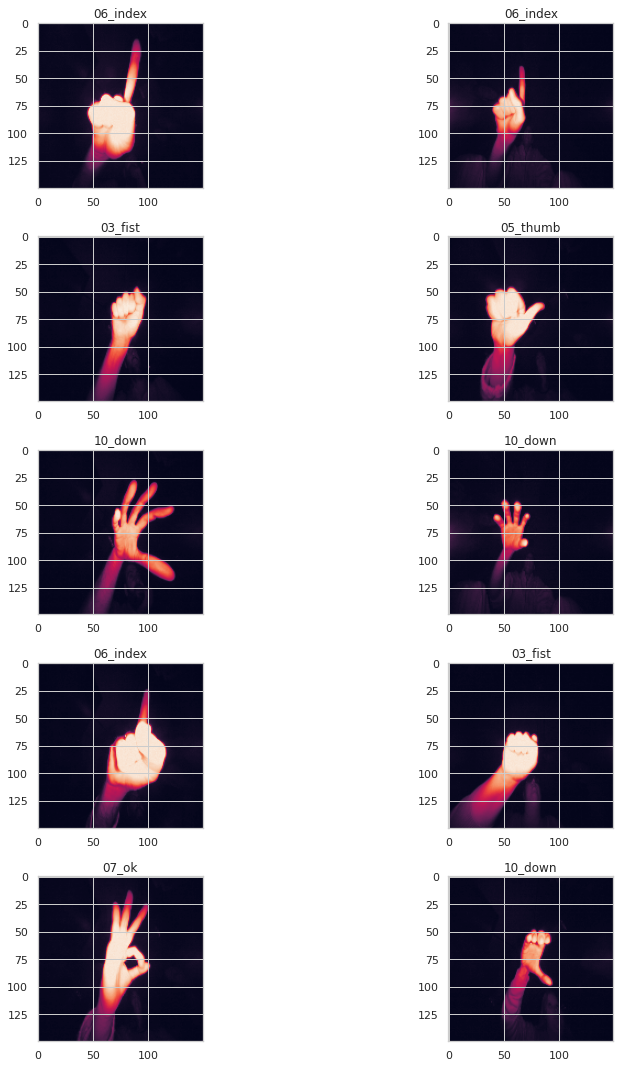

In [7]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(y_data))
        ax[i,j].imshow(x_data[l])
        ax[i,j].set_title(reverselookup[y_data[l,0]])
        
plt.tight_layout()

In [8]:
y_data=to_categorical(y_data)
x_data = x_data.reshape((datacount, IMG_SIZE, IMG_SIZE, 1))
x_data = x_data/255

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.25,random_state=42)

## Building Model

In [10]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10, activation = "softmax"))

2022-08-21 13:42:16.017834: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
batch_size=128
epochs=10

In [12]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

2022-08-21 13:42:20.720134: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-21 13:42:20.720339: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-08-21 13:42:20.721577: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [13]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 96)        8

## Training

In [15]:
History = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test),callbacks=callbacks)

2022-08-21 13:42:38.838257: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
  1/118 [..............................] - ETA: 6:52 - loss: 2.3018 - accuracy: 0.1016

2022-08-21 13:42:42.458686: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-08-21 13:42:42.459084: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/118 [..............................] - ETA: 3:46 - loss: 2.2908 - accuracy: 0.1094

2022-08-21 13:42:44.402183: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-21 13:42:44.408957: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-08-21 13:42:44.422258: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_08_21_13_42_44

2022-08-21 13:42:44.423721: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_08_21_13_42_44/d72ccd48a26f.trace.json.gz
2022-08-21 13:42:44.441114: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_08_21_13_42_44

2022-08-21 13:42:44.442099: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2022_08_21_13_42_44/d72ccd48a26f.memory_profile.json.gz
2022-08-21 13:42:44.4

118/118 [==============================] - 249s 2s/step - loss: 0.3741 - accuracy: 0.8799 - val_loss: 0.0102 - val_accuracy: 0.9972

Epoch 00001: val_loss improved from inf to 0.01019, saving model to ./base.model


2022-08-21 13:46:48.950181: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch 2/10
118/118 [==============================] - 247s 2s/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0036 - val_accuracy: 0.9994

Epoch 00002: val_loss improved from 0.01019 to 0.00356, saving model to ./base.model
Epoch 3/10
118/118 [==============================] - 246s 2s/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 0.0038 - val_accuracy: 0.9994

Epoch 00003: val_loss did not improve from 0.00356
Epoch 4/10
118/118 [==============================] - 244s 2s/step - loss: 5.5470e-04 - accuracy: 0.9999 - val_loss: 0.0015 - val_accuracy: 0.9996

Epoch 00004: val_loss improved from 0.00356 to 0.00154, saving model to ./base.model
Epoch 5/10
118/118 [==============================] - 246s 2s/step - loss: 4.6425e-05 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 0.9996

Epoch 00005: val_loss did not improve from 0.00154
Epoch 6/10
118/118 [==============================] - 246s 2s/step - loss: 9.5232e-06 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 0.99

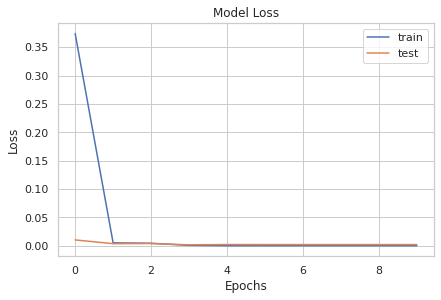

In [16]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

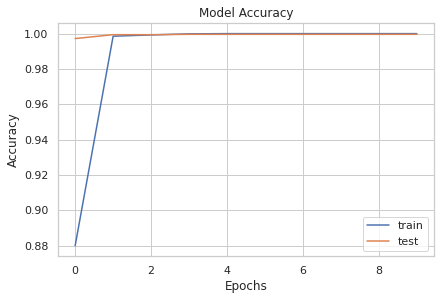

In [17]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()